# General Imports

In [ ]:
!pip install deepxde scipy numpy matplotlib

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Imports for solve_ivp

In [ ]:
from scipy.integrate import solve_ivp, odeint

# Imports for Keras

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import initializers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Imports for DeepXDE

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import deepxde as dde
from deepxde.backend import tf

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


# Constants

In [ ]:
q0 = 1
l = 1

activation = "tanh"
initializer = "Glorot uniform"
adam = "adam"
lbfgsb = "L-BFGS-B"
train_with_lbfgsb = False
lr = 0.001
metrics = ["l2 relative error"]
epochs = 10000
randomrange = 0.1
hidden_layer =  3
hidden_layer_neurons = 20
keras_resolution = 10

# General PINN Variables & Instances

In [ ]:
def ddy(x, y):
    return dde.grad.hessian(y, x)

def dddy(x, y):
    return tf.gradients(ddy(x, y), x)[0]

def pde(x, y):
    dy_xxxx = tf.gradients(dddy(x, y), x)[0]
    #Formel: E*I*w''''=q(x)
    return dy_xxxx - q0

def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

geom = dde.geometry.Interval(0, 1)

bc1 = dde.DirichletBC(geom, lambda x: 0, boundary_left)
bc2 = dde.NeumannBC(geom, lambda x: 0, boundary_left)
bc3 = dde.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_right)
bc4 = dde.OperatorBC(geom, lambda x, y, _: dddy(x, y), boundary_right)



# Helping Functions

In [ ]:
def fx(x):
    return ((q0/24) * (6*l**2*x**2 - 4*l*x**3 + x**4))

def to_numpy_array(arr):
    arr_formatted = []
    for i in arr:
        arr_formatted.append([i])
    return np.array(arr_formatted)

def get_delta(origarr, controllarr):
    if len(origarr) != len(controllarr):
        return False
    else:
        delta = []
        for i in range(len(origarr)):
            delta.append(controllarr[i] - origarr[i])
        return delta

def generate_x_testing(testing_xs):
    # generate all x for training
    x_testing = []
    for i in range(testing_xs):
        x_testing.append(i/(testing_xs - 1))
    return x_testing

def generate_y_testing(xs):
    ys = []
    for x in xs:
        ys.append(fx(x))
    return ys

def fx_randomized(x):
    return fx(x) * random.uniform(1-randomrange, 1+randomrange)

# solve_ivp

In [ ]:
def w4(x, y):
    return [y[1], y[2], y[3], q0]

y0 = [0, 0, 1, 1]

xs = []
for i in range(1000):
    xs.append(i/1000)
    
sol = solve_ivp(w4, [0, l], y0, max_step = 0.01, dense_output = True)

# Keras

In [ ]:
model = Sequential()
model.add(Dense(1, activation='tanh', input_shape=(1,)))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(1))

opt = Adam(learning_rate=lr)
model.compile(
    loss="mean_squared_error",
    optimizer=opt,
    metrics=['accuracy']
)

xs = []
ys = []

for x in range(keras_resolution + 1):
    xs.append(x/keras_resolution)
    ys.append(fx(x/keras_resolution))
  
history = model.fit(np.array(xs), np.array(ys), epochs=epochs, batch_size=1000)

keras_model = model

Train on 11 samples
Epoch 1/10000
11/11 [==============================] - 0s 5ms/sample - loss: 0.0061 - acc: 0.0909
Epoch 2/10000
11/11 [==============================] - 0s 0s/sample - loss: 0.0043 - acc: 0.0909
Epoch 3/10000
11/11 [==============================] - 0s 0s/sample - loss: 0.0031 - acc: 0.0909
Epoch 4/10000
11/11 [==============================] - 0s 0s/sample - loss: 0.0024 - acc: 0.0909
Epoch 5/10000
11/11 [==============================] - 0s 0s/sample - loss: 0.0021 - acc: 0.0909
Epoch 6/10000
11/11 [==============================] - 0s 0s/sample - loss: 0.0021 - acc: 0.0909
Epoch 7/10000
11/11 [==============================] - 0s 1ms/sample - loss: 0.0023 - acc: 0.0909
Epoch 8/10000
11/11 [==============================] - 0s 0s/sample - loss: 0.0025 - acc: 0.0909
Epoch 9/10000
11/11 [==============================] - 0s 0s/sample - loss: 0.0026 - acc: 0.0909
Epoch 10/10000
11/11 [==============================] - 0s 0s/sample - loss: 0.0025 - acc: 0.0909
Epoch 1

# PINN with true function for solution, not randomized


Compiling model...
Building feed-forward neural network...
'build' took 0.062507 s



C:\Users\klinDEV\anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\klinDEV\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 2.808963 s

Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [3.83e+00, 0.00e+00, 3.57e-01, 1.39e-01, 2.39e-02]    [3.94e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [5.65e+00]    
1000      [1.80e-03, 7.23e-07, 7.80e-05, 8.95e-04, 6.64e-05]    [1.88e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [1.77e-01]    
2000      [1.23e-04, 1.87e-08, 3.79e-08, 6.46e-07, 1.02e-08]    [1.57e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [3.80e-03]    
3000      [5.15e-05, 1.81e-10, 6.59e-09, 1.08e-07, 8.96e-09]    [6.31e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [1.83e-04]    
4000      [2.41e-05, 3.38e-13, 1.35e-09, 2.92e-08, 1.51e-08]    [2.87e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [6.20e-04]    
5000      [2.35e-05, 9.43e-09, 1.36e-10, 1.35e-07, 9.80e-07]    [2.19e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [1.21e-03]  

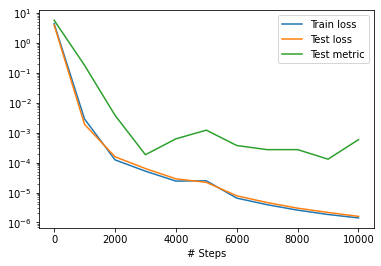

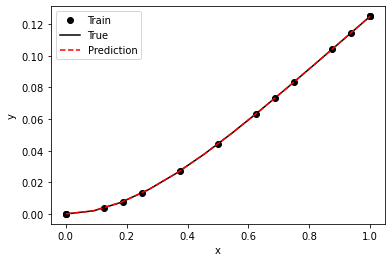

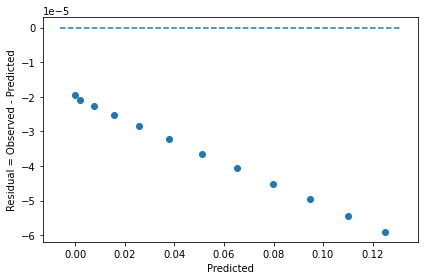

In [ ]:
data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2, bc3, bc4],
    num_domain=10,
    num_boundary=2,
    solution=fx,
    num_test=12,
)

layer_size = [1] + [hidden_layer_neurons] * hidden_layer + [1]

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile(adam, lr=lr, metrics=metrics)
losshistory, train_state = model.train(epochs=epochs)

if train_with_lbfgsb:
    model.compile(lbfgsb, metrics=metrics)
    losshistory, train_state = model.train()

dde.saveplot(losshistory, train_state, issave=False, isplot=True)

original_pinn_model = model

# PINN with randomized solution


Compiling model...
Building feed-forward neural network...
'build' took 0.073754 s



C:\Users\klinDEV\anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\klinDEV\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 3.292652 s

Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [9.39e+00, 0.00e+00, 4.18e-01, 1.73e-01, 2.40e-01]    [1.01e+01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [5.71e+00]    
1000      [8.60e-03, 3.99e-07, 5.88e-04, 7.71e-03, 9.71e-04]    [8.37e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [4.69e-01]    
2000      [1.91e-04, 1.40e-09, 1.73e-07, 2.95e-06, 4.55e-07]    [2.19e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [8.10e-03]    
3000      [5.56e-05, 2.49e-08, 1.29e-09, 4.89e-07, 1.26e-08]    [5.62e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [1.28e-02]    
4000      [6.13e-06, 1.17e-11, 2.25e-10, 9.14e-09, 2.61e-09]    [7.38e-06, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [1.36e-02]    
5000      [2.70e-06, 1.35e-12, 4.81e-11, 1.56e-09, 5.92e-10]    [3.42e-06, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [1.36e-02]  

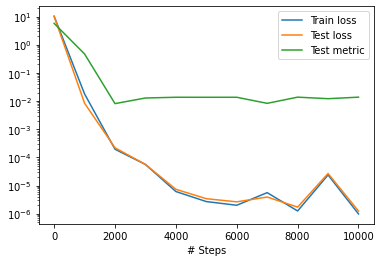

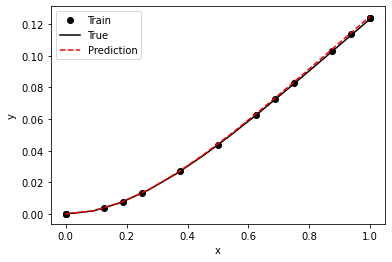

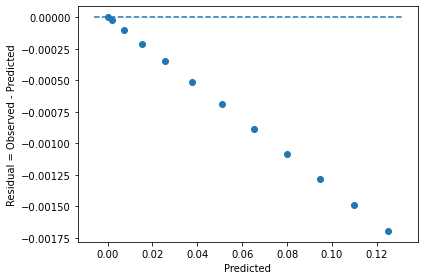

In [ ]:
data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2, bc3, bc4],
    num_domain=10,
    num_boundary=2,
    num_test = 12,
    solution=fx_randomized,
)
layer_size = [1] + [hidden_layer_neurons] * hidden_layer + [1]
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile(adam, lr=lr, metrics=metrics)
losshistory, train_state = model.train(epochs=epochs)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

randomized_pinn_model = model

# Bending Line Graph with solve_ivp

C:\Users\klinDEV\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


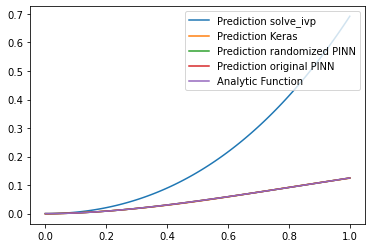

In [ ]:
testing_xs = 100
xs = generate_x_testing(testing_xs)
ys_function = generate_y_testing(xs)

predictions_solveivp =[]
for i in range(testing_xs):
    predictions_solveivp.append(sol.sol(i/testing_xs)[0])

predictions_keras = keras_model.predict(to_numpy_array(xs))
predictions_randomized = randomized_pinn_model.predict(to_numpy_array(xs))
predictions_original_pinn = original_pinn_model.predict(to_numpy_array(xs))

plt.plot(xs, predictions_solveivp, label='Prediction solve_ivp')
plt.plot(xs, predictions_keras, label='Prediction Keras')
plt.plot(xs, predictions_randomized, label='Prediction randomized PINN')
plt.plot(xs, predictions_original_pinn, label='Prediction original PINN')
plt.plot(xs, ys_function, label='Analytic Function')
plt.legend(loc='upper right')

# Bending Line Graph without solve_ivp

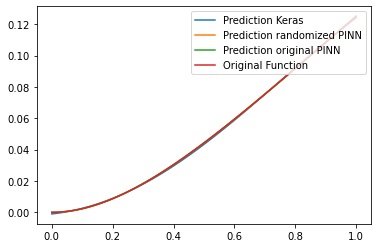

In [ ]:
plt.plot(xs, predictions_keras, label='Prediction Keras')
plt.plot(xs, predictions_randomized, label='Prediction randomized PINN')
plt.plot(xs, predictions_original_pinn, label='Prediction original PINN')
plt.plot(xs, ys_function, label='Original Function')
plt.legend(loc='upper right')

# Difference between solve_ivp and original function

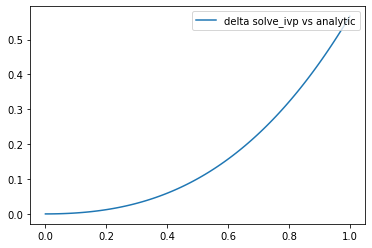

In [ ]:
delta_solveivp = get_delta(ys_function, predictions_solveivp)

plt.plot(xs, delta_solveivp, label='delta solve_ivp vs analytic')
plt.legend(loc='upper right')

# Difference between solutions of Neural Networks and original function

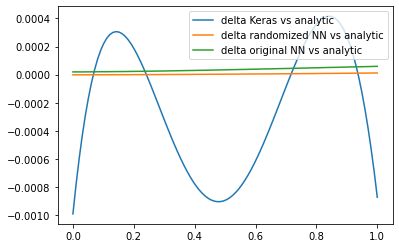

In [ ]:
delta_keras = get_delta(ys_function, predictions_keras)
delta_randomized = get_delta(ys_function, predictions_randomized)
delta_original_pinn = get_delta(ys_function, predictions_original_pinn)

plt.plot(xs, delta_keras, label='delta Keras vs analytic')
plt.plot(xs, delta_randomized, label='delta randomized NN vs analytic')
plt.plot(xs, delta_original_pinn, label='delta original NN vs analytic')
plt.legend(loc='upper right')